## Loading the data and the libraries

In [1]:
import os
print(os.getcwd())
os.chdir('./Documents/CSAI/Research Workshop/data from the main article') #fill the correct path in here

C:\Users\ninkh


In [2]:
print(os.getcwd()) #this prints your new working directory just to be sure

C:\Users\ninkh\Documents\CSAI\Research Workshop\data from the main article


In [3]:
from datetime import datetime
import pandas as pd
import numpy as np
import mglearn
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [4]:
dataAMB = pd.read_csv("./integrated16.csv")
labelsAMB = pd.read_csv("./Labels16.csv")

## Inspecting the data

In [5]:
print(type(dataAMB), dataAMB.shape)
print(type(labelsAMB), labelsAMB.shape)
print(dataAMB)
print(labelsAMB)

<class 'pandas.core.frame.DataFrame'> (2000, 1299)
<class 'pandas.core.frame.DataFrame'> (1298, 2)
     Unnamed: 0        X0        X1        X2        X3        X4        X5  \
0         Crhbp  0.044740  0.018913  0.002178  0.026894  0.887822  0.017641   
1           Npy  0.285523  0.515677  0.009491  0.109614  3.871232  0.080129   
2          Tac2  4.042708  3.856012  0.000040  0.045940  4.023202  0.003705   
3           Sst  1.553474 -0.039122  0.004313  1.660023  1.571740  1.475266   
4          Penk  2.752344  0.321618  0.002327  3.352981  0.207314  0.262003   
...         ...       ...       ...       ...       ...       ...       ...   
1995    Olfr653  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1996        Cd6  0.000041  0.000000  0.000057  0.000063  0.000000  0.057634   
1997     Sphkap  0.020487  0.034654  0.818970  1.187780  0.624451  1.662279   
1998    Gucy1a2  0.101706  1.328464  0.858349  0.387203  0.174547  1.657084   
1999        Erg  0.000113  0.001

## Preprocessing the data

In [7]:
Xa = np.transpose(dataAMB)
print(Xa.shape)
Xa = np.array(Xa[1:])
print(Xa.shape, type(Xa))
ya = np.array(labelsAMB["cluster"])
print(ya.shape)
print(ya)

(1299, 2000)
(1298, 2000) <class 'numpy.ndarray'>
(1298,)
['Vip Mybpc1' 'Vip Parm1' 'L4 Ctxn3' ... 'L6a Car12' 'L5a Batf3'
 'L6a Car12']


In [9]:
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, train_size = 0.8)
print("AMB splitted.")
print("Training set:",Xa_train.shape, ya_train.shape)
print("Test set:",Xa_test.shape, ya_test.shape)

AMB splitted.
Training set: (1038, 2000) (1038,)
Test set: (260, 2000) (260,)


## Fitting models into the AMB dataset

#### Creating datastructures in order to fit and measure the performance systematically:

In [11]:
#a list of model objects to be fit and measured:
models = [LogisticRegression(max_iter = 100000),
          KNeighborsClassifier(), 
          SVC(tol=0.00001),
          LinearSVC(max_iter = 100000), 
          RandomForestClassifier(),
          GradientBoostingClassifier() ]

#a list of string names of these models in order to not overload the storing process:
model_names = ["Logistic Regression", "kNNeighbor", "SVC", "LinearSVC", \
          "Random Forest", "Gradient Boosting"]

#a list of dictionaries with hyperparameters for respective models:
param_grid_all = []
param_grid_all.append({"C":[0.001, 0.01, 0.1, 1, 10, 100]})
param_grid_all.append({"n_neighbors": list(range(1,10))})
param_grid_all.append({"kernel":["linear","rbf","poly"],
                   "C":[0.01, 1, 10, 100]})
param_grid_all.append({"multi_class":['crammer_singer','ovr'],
                   "C":[0.01, 1, 10, 100]})
param_grid_all.append({"n_estimators":[50, 100, 150, 300], 
                   "max_depth":[1, 3, 6, 9]})
param_grid_all.append({"n_estimators":[1, 2, 3, 5],
                   "learning_rate":[0.05, 0.1, 0.15, 0.3]})

#empty arrays to store the results:
results = {} #create a datastructure storing the metrics of the models
training = [] #create a datastrucgture storing the computation times for training
testing = [] #this one will store the testing times

print("model :","hyperparameters to be used for tuning \n",sep = "\n")
for i in range(len(model_names)):
    print(model_names[i], ":")
    print(param_grid_all[i],"\n")

model :
hyperparameters to be used for tuning 

Logistic Regression :
{'C': [0.001, 0.01, 0.1, 1, 10, 100]} 

kNNeighbor :
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]} 

SVC :
{'kernel': ['linear', 'rbf', 'poly'], 'C': [0.01, 1, 10, 100]} 

LinearSVC :
{'multi_class': ['crammer_singer', 'ovr'], 'C': [0.01, 1, 10, 100]} 

Random Forest :
{'n_estimators': [50, 100, 150, 300], 'max_depth': [1, 3, 6, 9]} 

Gradient Boosting :
{'n_estimators': [1, 2, 3, 5], 'learning_rate': [0.05, 0.1, 0.15, 0.3]} 



#### Fitting models, measuring performance and recording results:

In [12]:
for i in range(len(model_names)):

    #creating the grid with hyperparameters:
    gs = GridSearchCV(models[i], param_grid_all[i], cv = 5)

    #tuning the hyperparameters:
    gs.fit(Xa_train,ya_train) #fit the model with the best hyperparameters
    
    #measuring the training time:
    start = datetime.now() #to measure how much it takes we record the start time
    gs.best_estimator_.fit(Xa_train,ya_train)
    end=datetime.now() #record the end time

    #recording training time:
    training.append((end-start).seconds+(end-start).microseconds/1000000) #in seconds

    #testing and recording test time:
    start = datetime.now() 
    score = gs.score(Xa_test,ya_test)
    end=datetime.now() 
    testing.append((end-start).seconds+(end-start).microseconds/1000000) #in seconds

    #recording metrics:
    pred = gs.predict(Xa_test) #generate a vector of predicted labels
    results[model_names[i]] = [gs.best_params_] #store the found hyperparameters
    results[model_names[i]].append(f1_score(ya_test, pred, average = "macro")) #store the F1
    results[model_names[i]].append(score) #add the accuracy to the datastructure storing the metrics
    results[model_names[i]].append(precision_score(ya_test, pred, zero_division = 1, average = "macro")) #store precision
    results[model_names[i]].append(recall_score(ya_test, pred, zero_division = 1, average = "macro")) #store recall
    results[model_names[i]].append(confusion_matrix(ya_test, pred)) #store confusion matrix

C:\Users\ninkh\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ninkh\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ninkh\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ninkh\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ninkh\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

## Exploring and exporting results

In [13]:
#look at the results:
for i in range(len(model_names)):
    print(model_names[i])
    for j in range(1,len(results[model_names[i]])-1):
        print(round(results[model_names[i]][j],2))
    print(round(training[i],2))
    print(round(testing[i],2))
    print("")

Logistic Regression
0.86
0.92
0.93
0.87
19.4
0.02

kNNeighbor
0.77
0.85
0.9
0.8
0.3
0.91

SVC
0.9
0.93
0.94
0.91
2.78
0.71

LinearSVC
0.84
0.91
0.92
0.86
5.44
0.0

Random Forest
0.84
0.88
0.89
0.86
8.76
0.03

Gradient Boosting
0.72
0.74
0.81
0.72
93.73
0.03



In [75]:
#Compiling all the results into a Pandas DataFrame object and exporting it for maybe future use. 
#Uncomment the last line to export.

df = pd.DataFrame(results, index =['Best hyperparameters',
                                'F1',
                                'Accuracy',
                                'Precision',
                                'Recall',
                                'Confusion matrix'])
df.loc[len(df.index)] = training
df.loc[len(df.index)] = testing
display(df)

df.rename(index={"6":"Training data (s)"},inplace=True)
df.rename(index={"7":"Testing data (s)"},inplace=True)
#df.to_csv("preferred name.csv")

,Logistic Regression,kNNeighbor,SVC,LinearSVC,Random Forest,Gradient Boosting
Best hyperparameters,{'C': 1},{'n_neighbors': 5},"{'C': 1, 'kernel': 'linear'}","{'C': 1, 'multi_class': 'crammer_singer'}","{'max_depth': 9, 'n_estimators': 300}","{'learning_rate': 0.3, 'n_estimators': 5}"
F1,0.859663,0.767138,0.898965,0.843273,0.835025,0.716274
Accuracy,0.919231,0.853846,0.934615,0.907692,0.884615,0.742308
Precision,0.93041,0.898702,0.940194,0.915299,0.891077,0.807722
Recall,0.869977,0.798364,0.911208,0.859582,0.86114,0.724563
Confusion matrix,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6,19.398,0.300141,2.78394,5.43603,8.75891,93.7314
7,0.015622,0.906267,0.711269,0,0.033361,0.031227


## Visualizing results

### Display the dataframe as a table

In [21]:
df = df.drop(['Confusion matrix','Best hyperparameters']) #get rid of not very perceivable parts of the dataframe
df = df.astype(np.float) 
df = df.round(decimals = 2) #make numbers easier to perceive
display(df)

,Logistic Regression,kNNeighbor,SVC,LinearSVC,Random Forest,Gradient Boosting
F1,0.86,0.77,0.90,0.84,0.84,0.72
Accuracy,0.92,0.85,0.93,0.91,0.88,0.74
Precision,0.93,0.90,0.94,0.92,0.89,0.81
Recall,0.87,0.80,0.91,0.86,0.86,0.72


### The metrics as a heatmap

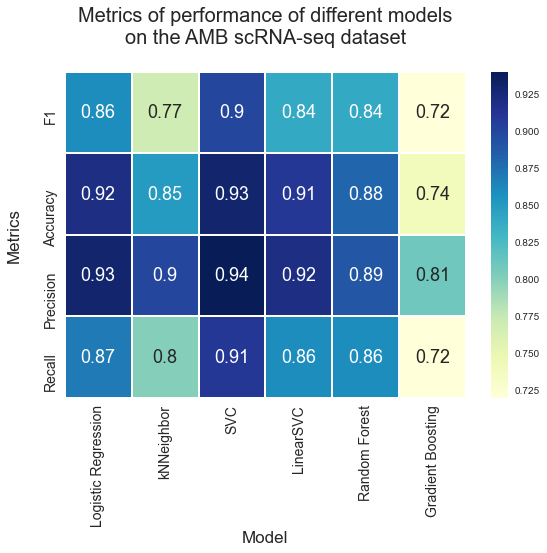

In [40]:
sns.set(font_scale=1.5) #controls the numeric labels within the heatmap
plt.style.use("seaborn")

plt.figure(figsize=(9,6))
heat_map = sns.heatmap(df, linewidth = 1 , annot = True, cmap="YlGnBu")
plt.xlabel('Model', fontsize=17);
plt.ylabel('Metrics\n', fontsize=17);
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title( "Metrics of performance of different models\non the AMB scRNA-seq dataset\n", fontsize = 20)
plt.show()

### Ranking according to the training time

In [68]:
#Visualizing the computational times as a sorted dataframe

#Because the absolute values of the training time depend on many technical parameters maybe more than on the
#model chosen only the relative performance of the algorithm on the same machine on the same software the same day
#makes sense. Therefore it makes sense to display the ranking of the algorithms according to the training time.

times = list(zip(training,testing))
times_df = pd.DataFrame(times, columns = ["Training time (s)",
                                          "Testing time (s)"],
                        index = model_names)
times_df = times_df.round(decimals = 2)
times_df = times_df.sort_values(by = "Training time (s)")
display(times_df)

,Training time (s),Testing time (s)
kNNeighbor,0.30,0.91
SVC,2.78,0.71
LinearSVC,5.44,0.00
Random Forest,8.76,0.03
Logistic Regression,19.40,0.02
Gradient Boosting,93.73,0.03
